# CHALLENGE 4
## Natural Language Processing
### Analysis of social media around #SOSMarMenor

In [269]:
import re

import matplotlib.pyplot as plt
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.lda_model
import requests
from IPython.display import HTML
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import spacy

pyLDAvis.enable_notebook()

1. **Data exploration**
In order to make a data exploration, we will use the tools given by 'Pandas' to get basic information about the dataset, so we can know what kind of data we are working with.

In [270]:
df = pd.read_csv('tweets.csv')

In [271]:
df

,Datetime,Tweet_Id,Text,Username,Reply_Count,Like_Count,Retweet_Count
0,2022-04-27 07:03:40+00:00,1519210655705972737,Agricultura y construcciones masivas y ningún...,Guzmani96580514,1,2,2
1,2022-04-27 06:47:37+00:00,1519206616431796224,El Instituto Oceanográfico alerta del riesgo d...,annamaryen,0,0,0
2,2022-04-27 06:45:23+00:00,1519206054457917440,#MarMenor\r\n#SOSMarMenor https://t.co/rC8vSspeKc,EcoantifaK,0,0,0
3,2022-04-27 05:57:18+00:00,1519193955166007297,#MarMenor\r\n#SOSMarMenor\r\n#AlertaMedioAmbie...,Strikebis,0,0,0
4,2022-04-27 05:57:15+00:00,1519193940985012224,#SOSMarMenor \r\n@IEOoceanografia alerta del r...,RafaSEF1,0,1,0
...,...,...,...,...,...,...,...
65573,2012-07-15 07:35:33+00:00,224406836554629120,Seguid destruyendo el Mar Menor y luego quejar...,zanguanga,0,3,13
65574,2012-07-11 12:26:33+00:00,223030514863448064,ANSE advierte a Valcárcel de que 'pagará el da...,zanguanga,0,0,0
65575,2012-07-10 18:41:13+00:00,222762417812291585,El Mar Menor podría ser un destino de primer n...,zanguanga,0,1,1
65576,2012-07-10 18:39:21+00:00,222761947647578113,Murcia podría haber sido un paraíso turístico ...,zanguanga,0,1,4


In [272]:
df.shape

(65578, 7)

In [273]:
df.describe()

,Tweet_Id,Reply_Count,Like_Count,Retweet_Count
count,6.557800e+04,65578.000000,65578.000000,65578.000000
mean,1.333442e+18,0.656196,11.595901,6.205602
std,1.249644e+17,5.124910,85.654005,49.232592
min,2.227583e+17,0.000000,0.000000,0.000000
25%,1.197089e+18,0.000000,0.000000,0.000000
50%,1.426811e+18,0.000000,2.000000,1.000000
75%,1.430935e+18,0.000000,6.000000,3.000000
max,1.519211e+18,682.000000,7624.000000,5479.000000


In [274]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65578 entries, 0 to 65577
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Datetime       65578 non-null  object
 1   Tweet_Id       65578 non-null  int64 
 2   Text           65578 non-null  object
 3   Username       65578 non-null  object
 4   Reply_Count    65578 non-null  int64 
 5   Like_Count     65578 non-null  int64 
 6   Retweet_Count  65578 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 3.5+ MB


In [275]:
df.isnull().sum()

Datetime         0
Tweet_Id         0
Text             0
Username         0
Reply_Count      0
Like_Count       0
Retweet_Count    0
dtype: int64

In [276]:
df.nunique()

Datetime         64553
Tweet_Id         65578
Text             64416
Username         10831
Reply_Count         98
Like_Count         486
Retweet_Count      356
dtype: int64

In [311]:
# Convert the 'Datetime' column to datetime type, will come handy later
df['Datetime'] = pd.to_datetime(df['Datetime'])

After the initial exploration, we can see that the dataset is composed of almost 65,000 rows and 7 columns. Each of these rows refers to a post from the social network Twitter and each of the columns provides the following information:
- **DateTime**: date of the post
- **Tweet_Id, Text**: identifier and content of the post
- **Username**: information about the user who posts the tweet
- **Reply_Count, Like_Count, Retweet_Count**: Tells the impact of the posts in different ways.

The data doesn't seem to have any missing or incorrect values.

As the last step of the data exploration, we will check the distribution of the length of the tweets.

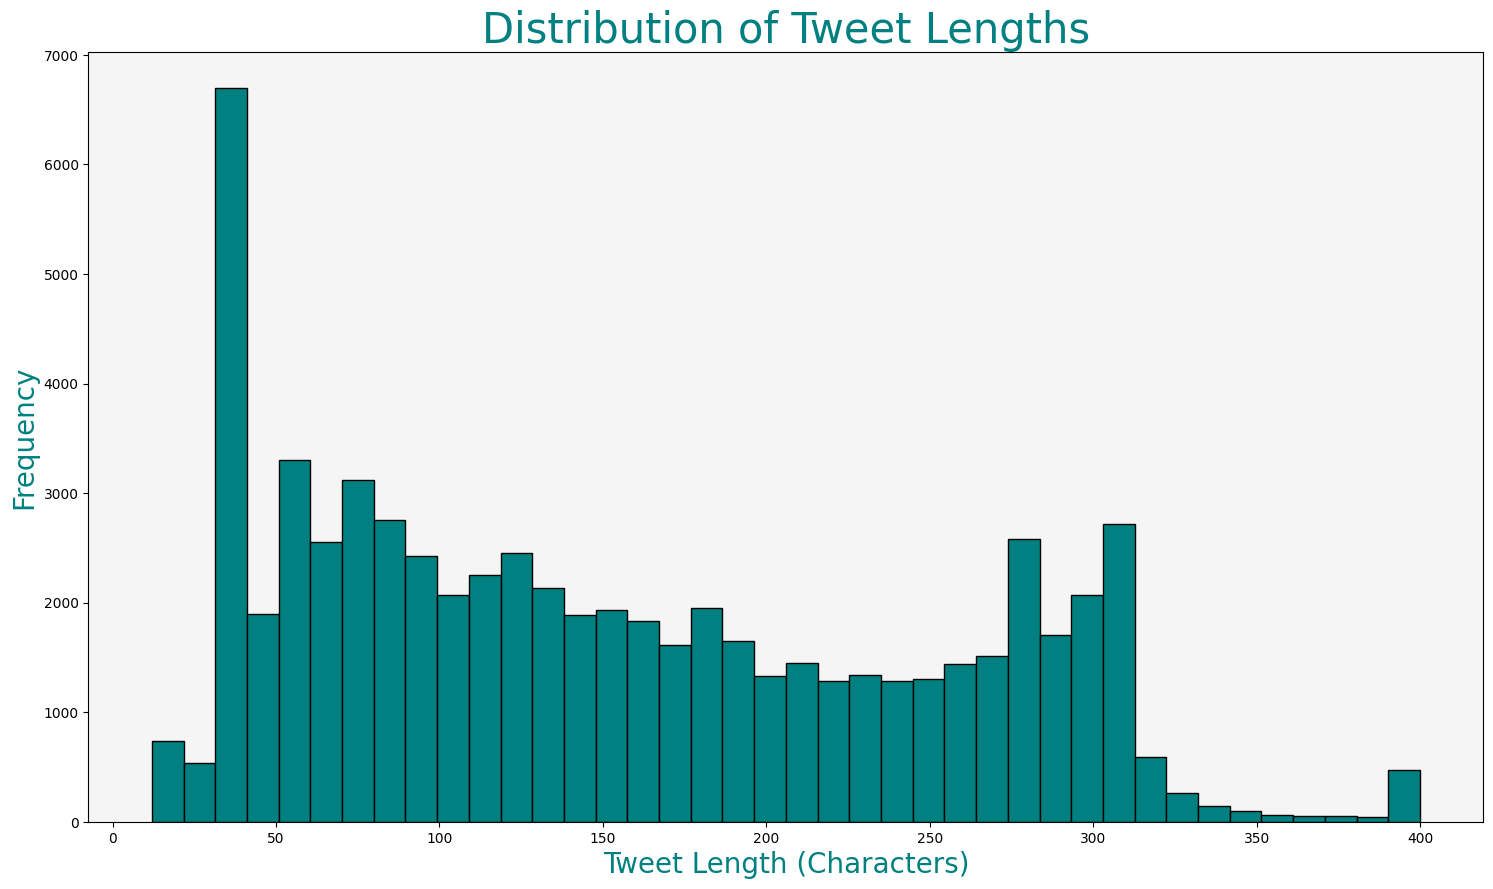

In [278]:
df['Tweet_Length'] = df['Text'].apply(len)
df['Tweet_Length'] = df['Tweet_Length'].clip(upper=400)  # Clip the length to 300 characters

figure = plt.figure(figsize=(18, 10))
axe = figure.add_subplot(1, 1, 1)
axe.hist(df['Tweet_Length'], bins=40, color='teal', edgecolor='black')
axe.set_title('Distribution of Tweet Lengths', color='teal', fontsize=30)
axe.set_xlabel('Tweet Length (Characters)', color='teal', fontsize=20)
axe.set_ylabel('Frequency', color='teal', fontsize=20)
axe.set_facecolor('whitesmoke')

As we can see on the graph, most of the tweets contain a fair amount of text, even if they are usually short, we can also see that it is common to find tweets with a length of up to 300 characters. This means we can probably extract a good amount of information from the tweets and making a topic modeling analysis could be interesting.

2. **Text pre-processing**
In order to sanitize the content of the tweets, we will perform the following steps:
- General sanitization: remove URLs, numbers and special characters
- Specific sanitization: remove hashtags and mentions

General sanitization

In [279]:
# Sanitize the tweets by removing unwanted data, but keeping hashtags and mentions
def sanitize_tweet(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)  # Remove URLs
    tweet = re.sub(r'\d+', '', tweet)  # Remove numbers
    tweet = re.sub(r'[^\w\s#@]', '', tweet)  # Remove special characters (punctuation/emojis)
    return tweet


df['tweet_sanitized'] = df['Text'].apply(sanitize_tweet)

Specific sanitization

In [280]:
# Define a list of spanish stops words and add some common words for this problem that will become redundant
stop_words = set(stopwords.words('spanish'))
stop_words.add('mar')
stop_words.add('menor')
stop_words.add('murcia')
stop_words.add('si')
stop_words.add('sos')

In [281]:
# Remove hashtags and mentions
def remove_hashtags_mentions(tweet):
    tweet = re.sub(r'@\w+', '', tweet)  # Remove mentions
    tweet = re.sub(r'#\w+', '', tweet)  # Remove hashtags
    tweet = re.sub(r'\s{2,}', ' ', tweet)  # Remove multiple spaces
    return tweet


def remove_stop_words(sentence):
    word_tokens = word_tokenize(sentence)
    filtered_sentence = [word for word in word_tokens if word.lower() not in stop_words]
    return ' '.join(filtered_sentence)


df['tweet_sanitized_no_hashtags_mentions'] = df['tweet_sanitized'].apply(remove_hashtags_mentions).apply(
    remove_stop_words)

3. **Exploratory Data Analysis**
In order to make an exploratory analysis of the data we will answer to the following questions:

In which periods has there been more citizen activity related to the hashtag #SOSMarMenor, what happened at those times?
- To answer this question, we will group the tweets by month and count the number of tweets for each month to see if there are any periods that stand out.

C:\Users\jsanchez\AppData\Local\Temp\ipykernel_13824\42396932.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year-month'] = df['Datetime'].dt.to_period('M')


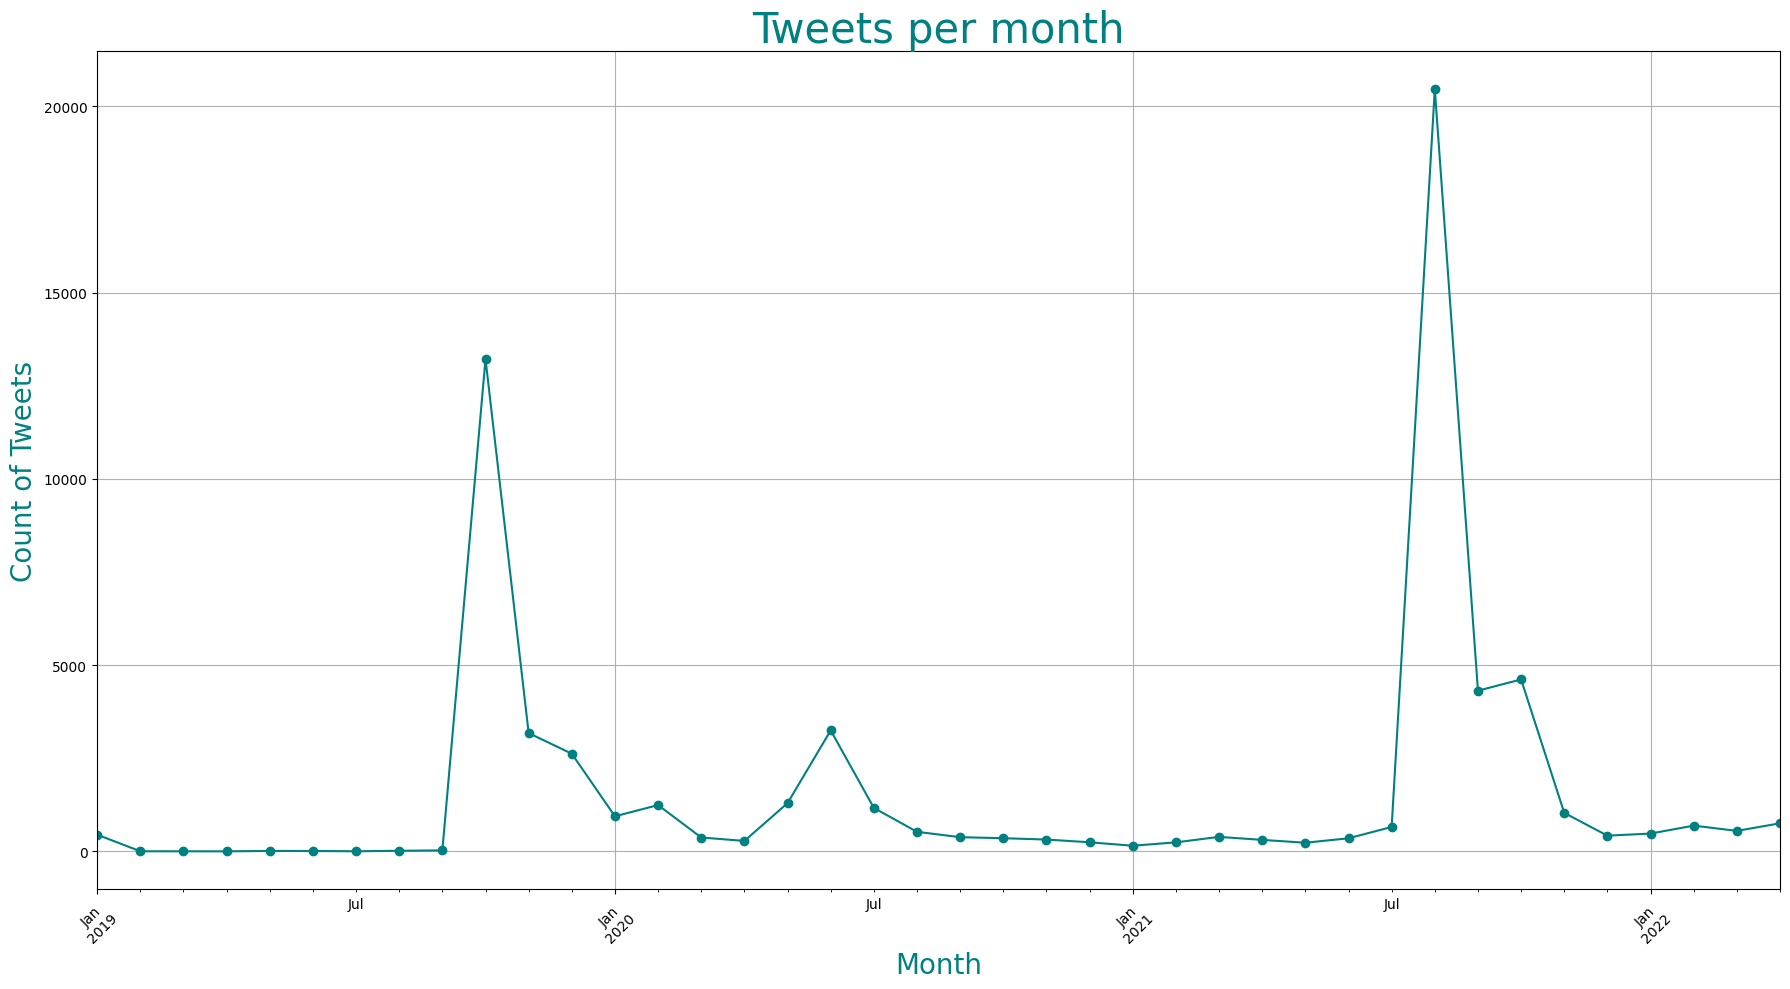

In [282]:
df['year-month'] = df['Datetime'].dt.to_period('M')
# Clip data to 2019 because there was barely any activity before that year
df['year-month'].clip(lower='2019-01', inplace=True)

# Group buy year-month and count the number of tweets
tweet_counts_by_month = df.groupby(df['year-month'])['Tweet_Id'].count()

plt.figure(figsize=(18, 10))
tweet_counts_by_month.plot(kind='line', marker='o', color='teal')
plt.title('Tweets per month', fontsize=30, color='teal')
plt.xlabel('Month', fontsize=20, color='teal')
plt.ylabel('Count of Tweets', fontsize=20, color='teal')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

- As the graph shows, the periods where the users with the most activity was during October 2019 and August 2021. Let's take a look at the tweets from those periods to see what happened.

In [283]:
nlp = spacy.load("es_core_news_lg")


def get_nouns(tweet):
    doc = nlp(tweet)
    nouns = [token.text for token in doc if token.pos_ == "NOUN"]
    return " ".join(nouns)

### 1st period: October 2019

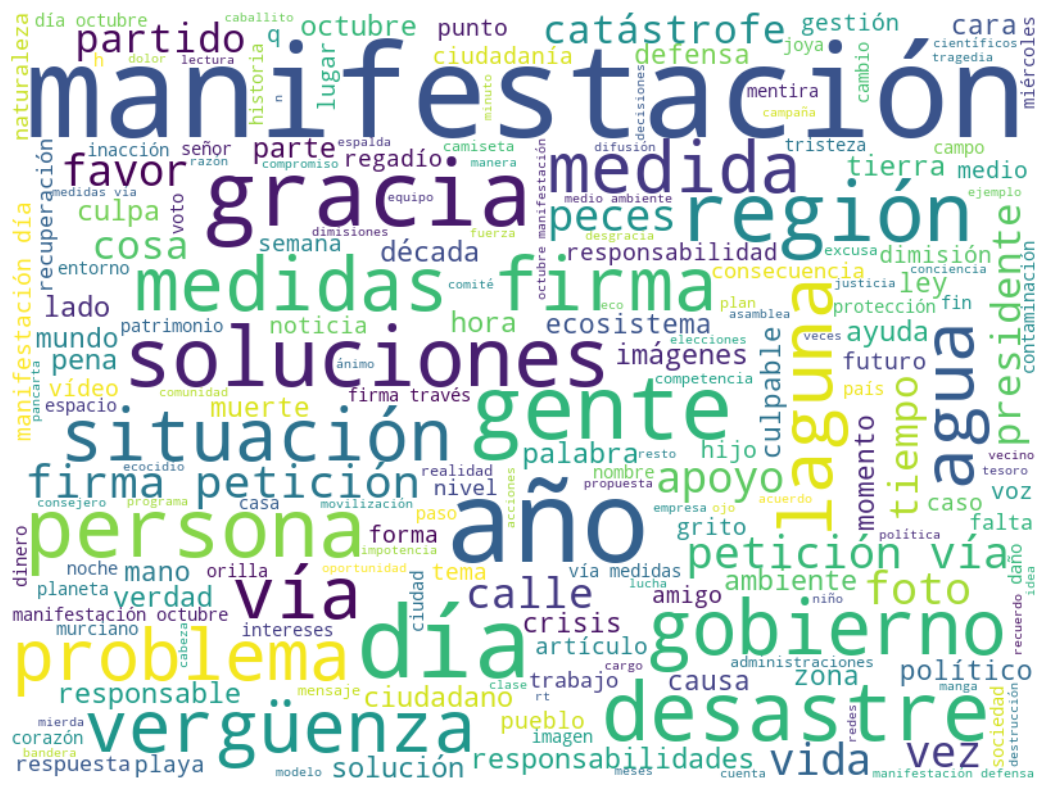

In [284]:
first_period = '2019-10'
tweets_first_period = df[df['year-month'] == first_period]

first_period_corpus = " ".join(
    sentence for sentence in tweets_first_period['tweet_sanitized_no_hashtags_mentions'].apply(get_nouns)
)

second_period_wordcloud = WordCloud(
    background_color='white',
    width=800,
    height=600,
    max_font_size=100
).generate(first_period_corpus)

# Display the generated WordCloud
plt.figure(figsize=(18, 10))
plt.imshow(second_period_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

- On October 12, 2019, the *Mar Menor* suffered one of the worst floods in its history, which caused the entry of fresh water and sludge into the *Mar Menor*, resulting in the death of thousands of fish and the degradation of the salt lagoon. The society mobilized to call for a big protest on October 30th, to ask for solutions to the political representatives. This demonstration was largely promoted through social networks, as can be seen in the wordcloud.

### 2nd period: August 2021

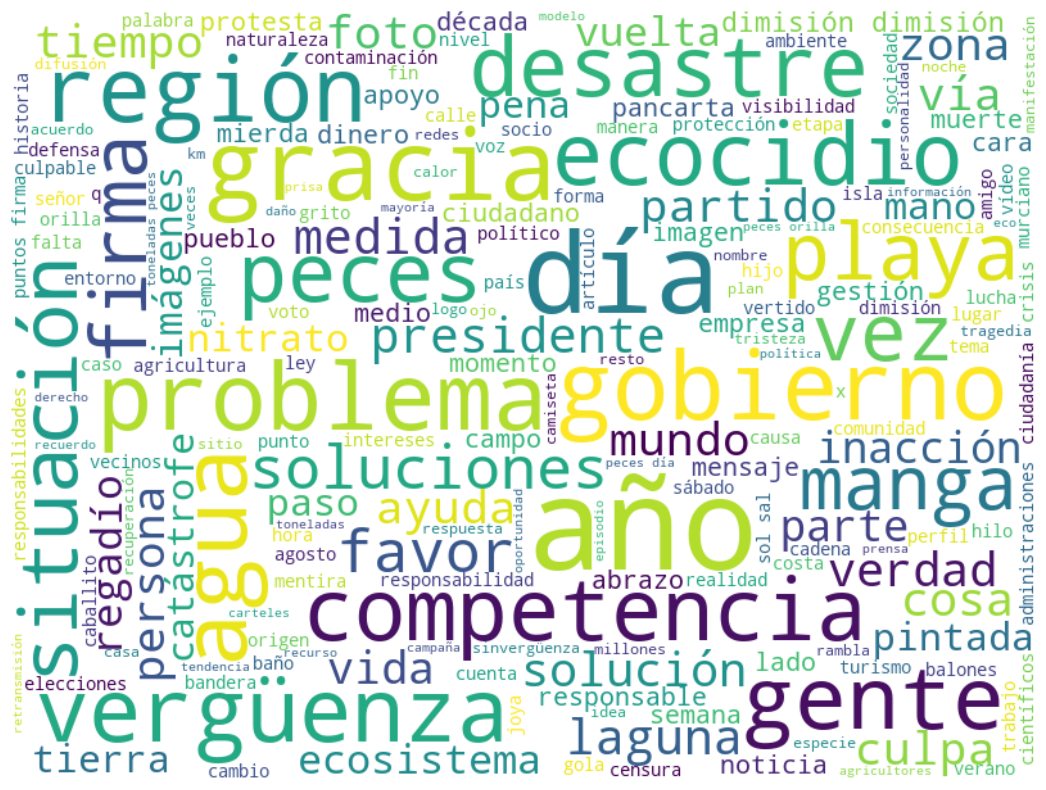

In [285]:
second_period_range = '2021-08'
second_period_tweets = df[df['year-month'] == second_period_range]

second_period_corpus = " ".join(
    sentence for sentence in second_period_tweets['tweet_sanitized_no_hashtags_mentions'].apply(get_nouns)
)

second_period_wordcloud = WordCloud(
    background_color='white',
    width=800,
    height=600,
    max_font_size=100
).generate(second_period_corpus)

# Display the generated WordCloud
plt.figure(figsize=(18, 10))
plt.imshow(second_period_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

During the month of August 2021, hundreds of thousands of fish appeared dead on the shore of the *Mar Menor* due to another episode of anoxia. Society once again took to the social networks to denounce the situation and ask political representatives for solutions. The indignation and concern about the state of the *Mar Menor* is reflected in the wordcloud. In addition, this episode coincided with a stage of the Tour of Spain, which made the news had a greater media coverage.

How many users have generated tweets related to the hashtag #SOSMarMenor?

In [286]:
unique_users = df['Username'].nunique()
print(f'A total of {unique_users} unique users have made tweets using the hashtag')

A total of 10831 unique users have made tweets using the hashtag


Who are the most active users, are they political parties, NGOs or citizen platforms, or private individuals?

In [287]:
# Get the top 10 most active users
tweets_per_user = df['Username'].value_counts().head(10)
tweets_per_user

Username
KlimoMur          1885
Miguel_Egea        893
Mariloliana        866
ono_murcia         743
sosmarmenorofi     728
SiemprefuenT       716
MariaLucha60       697
YanFickerRuiz      660
FAVCAC1            538
MenorSos           520
Name: count, dtype: int64

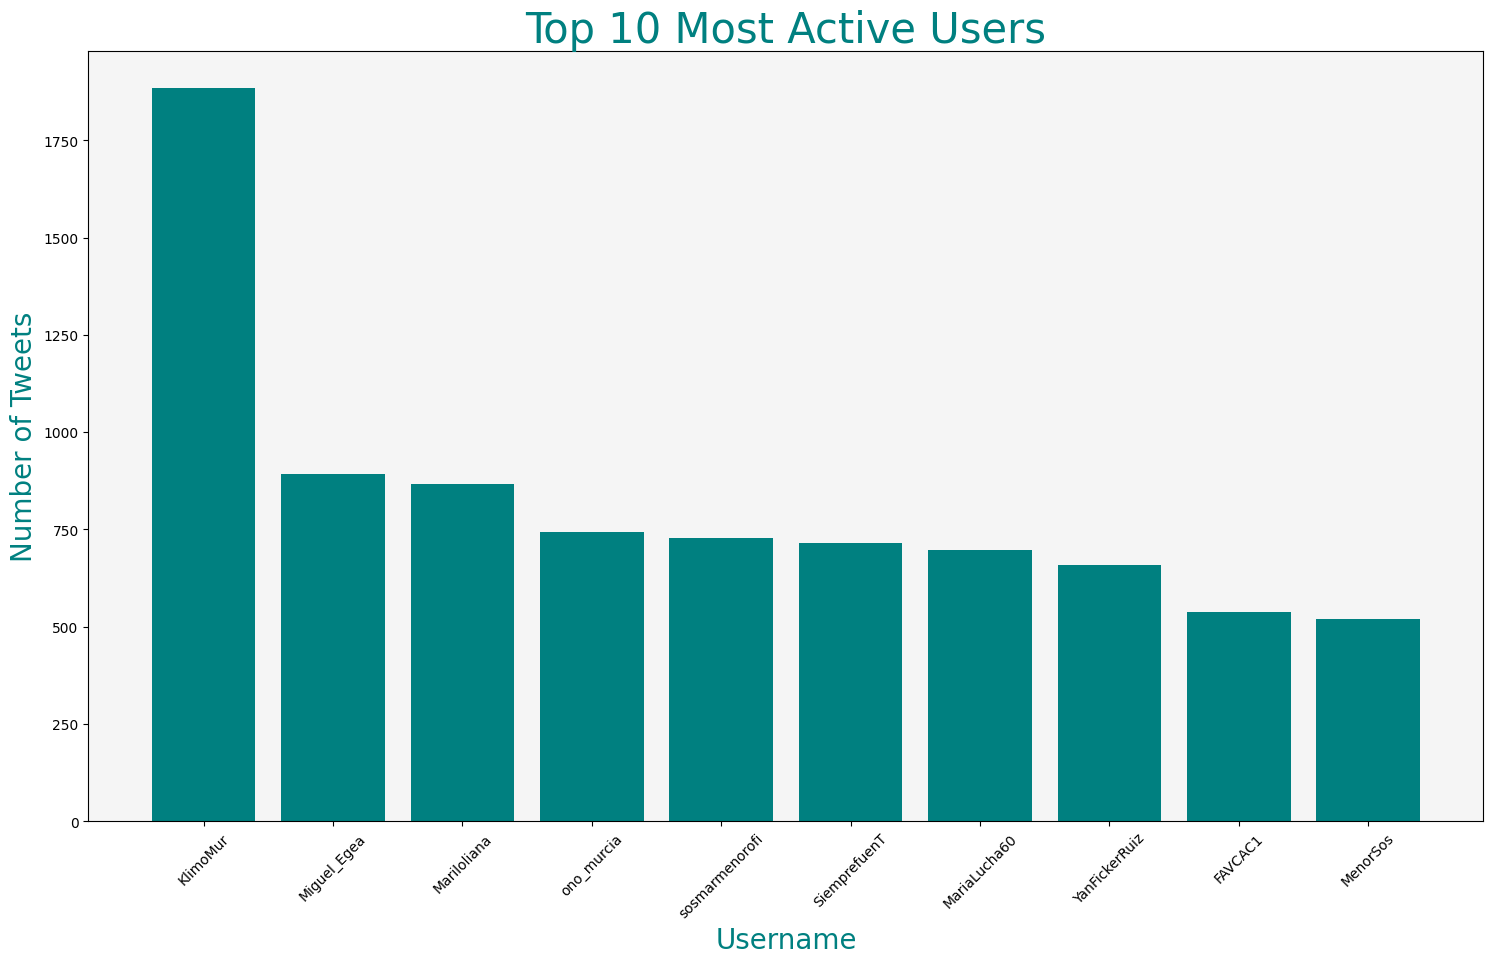

In [288]:
figure = plt.figure(figsize=(18, 10))
axe = figure.add_subplot(1, 1, 1)
axe.bar(tweets_per_user.index, tweets_per_user.values, color='teal')
axe.set_title('Top 10 Most Active Users', color='teal', fontsize=30)
axe.set_xlabel('Username', color='teal', fontsize=20)
axe.set_ylabel('Number of Tweets', color='teal', fontsize=20)
axe.set_xticks(tweets_per_user.index)
axe.set_xticklabels(tweets_per_user.index, rotation=45)
axe.set_facecolor('whitesmoke')


After finding out which accounts where the most active, we can make a short investigation about who owns these accounts. Looking at Twitter we can see that the most active users are mostly both individual users and citizen platforms. These users are from or live in Murcia and are take environment as a really serious matter.

- What were the most celebrated (i.e. retweeted) tweets, what kind of messages did they convey (protest, outrage, encouragement, solidarity)?

In [289]:
# Displays a tweet based on its id and the user's name
def show_tweet(user, tweet_id):
    url = 'https://twitter.com/' + user + '/status/' + str(tweet_id)
    url_to_json = 'https://publish.twitter.com/oembed?url=%s' % url
    response = requests.get(url_to_json)
    html = response.json()["html"]
    display(HTML(html))

In [290]:
popular_tweets = df.sort_values(by='Retweet_Count', ascending=False)
popular_tweets

,Datetime,Tweet_Id,Text,Username,Reply_Count,Like_Count,Retweet_Count,Tweet_Length,tweet_sanitized,tweet_sanitized_no_hashtags_mentions,year-month
28178,2021-08-21 10:56:59+00:00,1429034792310517761,Hoy La Vuelta Ciclista a España llega a la Man...,JulianMaciasT,107,5238,5479,306,hoy la vuelta ciclista a españa llega a la man...,hoy vuelta ciclista españa llega manga millone...,2021-08
54836,2019-10-30 17:48:47+00:00,1189600044762181636,En Cartagena la gente dice #SOSMarMenor https:...,mallemar,169,7624,3772,63,en cartagena la gente dice #sosmarmenor,cartagena gente dice,2019-10
64798,2019-10-12 19:02:47+00:00,1183095687543689216,Lo del Mar Menor es una JODIDA VERGÜENZA.\r\n\...,DrBioblogo,130,2488,3575,240,lo del mar menor es una jodida vergüenza\r\n\r...,jodida vergüenza paran llegar videos casi toda...,2019-10
64839,2019-10-12 18:36:29+00:00,1183089070710362114,"El mar es vida, hay vida y nace vida. Menos el...",AlejandroSanz,377,5023,2640,158,el mar es vida hay vida y nace vida menos el #...,vida vida nace vida menos muere cada segundo m...,2019-10
22491,2021-08-22 10:01:53+00:00,1429383315891625988,#SOSMarMenor https://t.co/6U7kPvivdf,Hoyuelicos,15,7262,2369,36,#sosmarmenor,,2021-08
...,...,...,...,...,...,...,...,...,...,...,...
38369,2020-07-10 13:52:33+00:00,1281587115751596035,@AlbaladejoPress @laster Si hay que elegir ent...,isabellacer,0,1,0,303,@albaladejopress @laster si hay que elegir ent...,elegir susto muerte inteligente elegir susto p...,2020-07
14294,2021-08-28 20:10:16+00:00,1431710745666985997,Playa de los Alemanes.\r\n\r\n#AbracemosAlMarM...,ono_murcia,0,1,0,317,playa de los alemanes\r\n\r\n#abracemosalmarme...,playa alemanes,2021-08
14293,2021-08-28 20:10:19+00:00,1431710758925217796,#SOSMarMenor https://t.co/KuLvPbgDLM,cornerfranke,0,0,0,36,#sosmarmenor,,2021-08
14291,2021-08-28 20:13:01+00:00,1431711436514996233,@LopezMirasF Diles a tus amos que dejen de cul...,unjuncoinfinito,0,1,0,112,@lopezmirasf diles a tus amos que dejen de cul...,diles amos dejen cultivar ilegalmente dejen echar,2021-08


In [291]:
# Show the most popular tweets
for idx in range(5):
    show_tweet(popular_tweets.iloc[idx]['Username'], popular_tweets.iloc[idx]['Tweet_Id'])

- The most popular tweets are mostly about the indignation and the protest of the citizens about the situation of the Mar Menor. There are also celebrities showing support to the citizens and some users using ironic tweets with memes to criticise the situation.

## Models

In [292]:
TOPIC_COUNT = 3
RANDOM_STATE = 2055

corpus = df['tweet_sanitized_no_hashtags_mentions']

In [293]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
terms_dictionary = vectorizer.get_feature_names_out()

### Topic modeling

In [294]:
def create_lda_model(data, topic_number):
    model = LatentDirichletAllocation(n_components=topic_number, max_iter=5, random_state=RANDOM_STATE)
    model.fit(data)

    doc_topic_distribution = model.transform(data)
    topic_word_distribution = model.components_

    return model, doc_topic_distribution, topic_word_distribution

In [295]:
def print_lda_topics(topic_word_distribution, feature_names, top_word_number=5):
    print("\nDistribución de palabras para cada tópico:")
    for i, topic_words in enumerate(topic_word_distribution):
        top_words_indices = topic_words.argsort()[-top_word_number:][::-1]
        top_words = [feature_names[index] for index in top_words_indices]
        print(f"Tópico {i + 1}: {top_words}")

In [296]:
def display_lda_topics(model, X, vectorizer):
    panel = pyLDAvis.lda_model.prepare(model, X, vectorizer, mds='tsne')
    return pyLDAvis.display(panel)

In [297]:
lda_model, lda_doc_topic_distribution, lda_topic_word_distribution = create_lda_model(X, TOPIC_COUNT)

In [298]:
print_lda_topics(lda_topic_word_distribution, terms_dictionary)


Distribución de palabras para cada tópico:
Tópico 1: ['día', 'hoy', 'manifestación', 'años', 'gente']
Tópico 2: ['gracias', 'gobierno', 'región', 'regional', 'problema']
Tópico 3: ['medidas', 'firma', 'urgentes', 'exigimos', 'vía']


In [299]:
display_lda_topics(lda_model, X, vectorizer)

### K-means

In [300]:
def create_kmeans_model(data, cluster_number):
    model = KMeans(n_clusters=cluster_number, init="k-means++", max_iter=50, n_init=10, random_state=RANDOM_STATE)
    model.fit(data)
    return model

In [301]:
def print_kmeans_clusters(centroids, feature_names, top_word_number=5):
    for i in range(TOPIC_COUNT):
        print(f"Cluster {i + 1}: ")
        for ind in centroids[i, :top_word_number]:
            print(f'{feature_names[ind]}', end=" ")
        print("\n")

In [302]:
kmeans_model = create_kmeans_model(X, TOPIC_COUNT)
order_centroids = kmeans_model.cluster_centers_.argsort()[:, ::-1]

In [303]:
print_kmeans_clusters(order_centroids, terms_dictionary)

Cluster 1: 
gracias hoy día gobierno región 

Cluster 2: 
años hace gobierno pp región 

Cluster 3: 
ver cómo hoy así vez 


### Results & Conclusions

In [304]:
df.replace('', pd.NA, inplace=True)
df.dropna(subset=['tweet_sanitized_no_hashtags_mentions'], inplace=True)

In [305]:
tweets_random = df.sample(10, random_state=22)

In [309]:
results = []
for idx, tweet in tweets_random.iterrows():
    lda_prediction = lda_model.transform(vectorizer.transform([tweet['tweet_sanitized_no_hashtags_mentions']]))
    kmeans_prediction = kmeans_model.predict(vectorizer.transform([tweet['tweet_sanitized_no_hashtags_mentions']]))
    results.append([
        idx,
        tweet['tweet_sanitized_no_hashtags_mentions'],
        f'{lda_prediction[0].argmax() + 1} ({" ".join(terms_dictionary[ind] for ind in lda_topic_word_distribution[lda_prediction[0].argmax()].argsort()[-5:][::-1])})',
        f'{kmeans_prediction[0]} ({" ".join(terms_dictionary[ind] for ind in order_centroids[kmeans_prediction[0], :5])})'
    ])

results_df = pd.DataFrame(results, columns=['idx', "documents", "LDA", "KMeans"])
results_df

,idx,documents,LDA,KMeans
0,45803,rambla carrasquilla desemboca lengua vaca día ...,3 (medidas firma urgentes exigimos vía),0 (gracias hoy día gobierno región)
1,62626,muero,1 (día hoy manifestación años gente),0 (gracias hoy día gobierno región)
2,56746,cómo presenta tarde partir horas cielo tierra ...,2 (gracias gobierno región regional problema),0 (gracias hoy día gobierno región)
3,54296,queremos muerto,1 (día hoy manifestación años gente),0 (gracias hoy día gobierno región)
4,34598,alumnado infantil años disfrutado lindo guardi...,2 (gracias gobierno región regional problema),1 (años hace gobierno pp región)
5,7881,gracias preciosas fotos peor aún conscientes t...,1 (día hoy manifestación años gente),2 (ver cómo hoy así vez)
6,33572,preocupa futuro necesitamos recoger firmas tre...,1 (día hoy manifestación años gente),0 (gracias hoy día gobierno región)
7,54669,españa siglo xxi empieza,3 (medidas firma urgentes exigimos vía),0 (gracias hoy día gobierno región)
8,27760,venga ayudadnos difundir,3 (medidas firma urgentes exigimos vía),0 (gracias hoy día gobierno región)
9,31514,ser intervenga justicia urgencia,2 (gracias gobierno región regional problema),0 (gracias hoy día gobierno región)


### Results

In [310]:
print('Selection of random tweets and their topic assigned (LDA vs K-means)')
for idx, tweet in tweets_random.iterrows():
    print(f'\nTweet {idx}:')
    print(f'\t- LDA → {results_df[results_df["idx"] == idx]["LDA"].values[0]}')
    print(f'\t- K-Means → {results_df[results_df["idx"] == idx]["KMeans"].values[0]}')
    show_tweet(tweet['Username'], tweet['Tweet_Id'])

Selection of random tweets and their topic assigned (LDA vs K-means)

Tweet 45803:
	- LDA → 3 (medidas firma urgentes exigimos vía)
	- K-Means → 0 (gracias hoy día gobierno región)



Tweet 62626:
	- LDA → 1 (día hoy manifestación años gente)
	- K-Means → 0 (gracias hoy día gobierno región)



Tweet 56746:
	- LDA → 2 (gracias gobierno región regional problema)
	- K-Means → 0 (gracias hoy día gobierno región)



Tweet 54296:
	- LDA → 1 (día hoy manifestación años gente)
	- K-Means → 0 (gracias hoy día gobierno región)



Tweet 34598:
	- LDA → 2 (gracias gobierno región regional problema)
	- K-Means → 1 (años hace gobierno pp región)



Tweet 7881:
	- LDA → 1 (día hoy manifestación años gente)
	- K-Means → 2 (ver cómo hoy así vez)



Tweet 33572:
	- LDA → 1 (día hoy manifestación años gente)
	- K-Means → 0 (gracias hoy día gobierno región)



Tweet 54669:
	- LDA → 3 (medidas firma urgentes exigimos vía)
	- K-Means → 0 (gracias hoy día gobierno región)



Tweet 27760:
	- LDA → 3 (medidas firma urgentes exigimos vía)
	- K-Means → 0 (gracias hoy día gobierno región)



Tweet 31514:
	- LDA → 2 (gracias gobierno región regional problema)
	- K-Means → 0 (gracias hoy día gobierno región)


### Conclusions

In order to get valuable data from the tweets, we have performed explored, pre-processed and analysed the contents of the tweets with the help of topic modeling and clustering techniques. The main focus of this project is to understand the main topics of the tweets and the main concerns of the citizens. These are the main conclusions we have reached: 

- The LDA model has been able to identify the main topics of the tweets, which are related to the environmental situation of the Mar Menor, the protests and the political situation. As we can see in these last examples, the model is able to identify the main topic of the tweets with a pretty good accuracy.

- The K-means model, on the other hand, has not been as accurate with their groups. As we can see in the examples, most of the tweets are grouped under the same cluster, and the cluster themselves are rather generic and not very descriptive of the content of the tweets.

**In summary, making use of the topic modeling techniques helped us in a great way to understand the main topics of the tweets and the main concerns of the citizens and how they are answering.** This tool can be really useful to decide how a journalist can approach an article, focusing on the main topics given by the model.